In [38]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd /content/gdrive/My \Drive/Code/302
!pwd

/content/gdrive/.shortcut-targets-by-id/1lAu0zBEWtPcALcBQIX-Letf0HRnuPJJX/Code/302
/content/gdrive/.shortcut-targets-by-id/1lAu0zBEWtPcALcBQIX-Letf0HRnuPJJX/Code/302


In [3]:
import random
import sys

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, utils, models
from hex import *
import util
import move_evaluator
import move_generator

## Get data

In [4]:
# data = pd.read_csv("./state_action.csv")
games = pd.read_csv("./finaldataframe.csv")

In [5]:
games.shape

(45446, 8)

In [6]:
(games['black_rating'].mean()+games['white_rating'].mean())/2

1731.6187783303262

Text(0, 0.5, 'number of games')

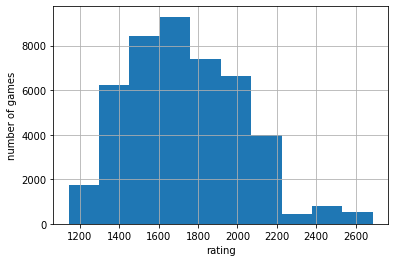

In [7]:
games['black_rating'].hist()
plt.xlabel('rating')
plt.ylabel('number of games')

## Preprocess data

In [8]:
games = games[games["move_list"].str.len() > 6]
games = games[~games['move_list'].str.contains('*', regex=False)]
print(len(games))

boards, actions = util.makeInputOutputTotal(games["move_list"].values,
                                            scraped=True)

boards = np.swapaxes(np.swapaxes(boards, 1, 2), 2, 3)

23475


In [9]:
print(boards.shape)

(808457, 17, 17, 2)


## Model training

In [10]:
w = 128
d = 5
model = tf.keras.Sequential([
    layers.Conv2D(w, kernel_size=(5, 5),
                  activation='relu',
                  input_shape=(17, 17, 2),
                  padding="same"
                 )
])
for i in range(d-1):
    model.add(layers.Conv2D(w, (3, 3), activation ="relu", padding="same"))

model.add(layers.Conv2D(1, (1, 1), activation = None, padding="same"))
model.add(layers.Flatten())
model.add(layers.Dense(169, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy']
             )

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 17, 17, 128)       6528      
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 128)       147584    
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       147584    
                                                                 
 conv2d_3 (Conv2D)           (None, 17, 17, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 17, 17, 128)       147584    
                                                                 
 conv2d_5 (Conv2D)           (None, 17, 17, 1)         129       
                                                                 
 flatten (Flatten)           (None, 289)               0

In [14]:
model.fit(boards.reshape(list(boards.shape)), actions, epochs=20, validation_split=0.10, verbose=1, batch_size=128)

Epoch 1/20
5685/5685 [==============================] - 111s 20ms/step - loss: 2.1703 - accuracy: 0.4622 - val_loss: 2.2534 - val_accuracy: 0.4482
Epoch 2/20
5685/5685 [==============================] - 111s 20ms/step - loss: 2.0737 - accuracy: 0.4807 - val_loss: 2.2345 - val_accuracy: 0.4523
Epoch 3/20
5685/5685 [==============================] - 111s 20ms/step - loss: 2.0081 - accuracy: 0.4926 - val_loss: 2.2291 - val_accuracy: 0.4505
Epoch 4/20
5685/5685 [==============================] - 111s 20ms/step - loss: 1.9556 - accuracy: 0.5024 - val_loss: 2.2835 - val_accuracy: 0.4500
Epoch 5/20
5685/5685 [==============================] - 111s 20ms/step - loss: 1.9120 - accuracy: 0.5104 - val_loss: 2.2657 - val_accuracy: 0.4449
Epoch 6/20
5685/5685 [==============================] - 111s 20ms/step - loss: 1.8737 - accuracy: 0.5184 - val_loss: 2.2790 - val_accuracy: 0.4451
Epoch 7/20
5685/5685 [==============================] - 111s 20ms/step - loss: 1.8392 - accuracy: 0.5249 - val_loss: 2

In [15]:
model.save('./full.h5')

### Plot training

In [31]:
epoch_data = pd.read_csv('./training_full.csv')
epoch_data

,epoch,train_loss,train_accuracy
0,1,2.1703,0.4622
1,2,2.0737,0.4807
2,3,2.0081,0.4926
3,4,1.9556,0.5024
4,5,1.9120,0.5104
5,6,1.8737,0.5184
6,7,1.8392,0.5249
7,8,1.8084,0.5308
8,9,1.7804,0.5362
9,10,1.7548,0.5418


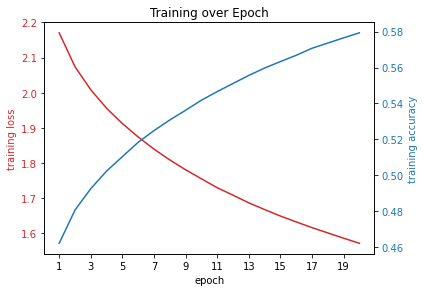

In [33]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('epoch')
ax1.set_ylabel('training loss', color=color)
ax1.plot(epoch_data['epoch'], epoch_data['train_loss'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('training accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(epoch_data['epoch'], epoch_data['train_accuracy'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.xticks(np.arange(min(epoch_data['epoch']), max(epoch_data['epoch'])+1, 2.0))

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Training over Epoch')
# plt.savefig('q1.png')
plt.show()

## Load Model(s)

In [19]:
model = models.load_model('./full.h5')
hexai_model = models.load_model('./best_so_far_dropout.h5')

## Gather winrates

In [28]:
# num games to simulate
n=100

### Model (White) vs Random

In [34]:
p1 = player.ModelPlayer(move_generator.ExhaustiveGenerator(), move_evaluator.ModelMoveEvaluator(model))

wc_r_w = 0
for i in range(n):
  game = Game(RandomPlayer(), p1)
  movelist, winner = game.play(verbose=False)
  if winner=='white':
    wc_r_w+=1
print(wc_r_w/n)

0.44


### Model (Black) vs Random

In [35]:
wc_r_b = 0
for i in range(n):
  game = Game(p1, RandomPlayer())
  movelist, winner = game.play(verbose=False)
  if winner=='black':
    wc_r_b+=1
print(wc_r_b/n)


0.65


### Model (White) vs HexAi

In [36]:
p2 = player.ModelPlayer(move_generator.ExhaustiveGenerator(), move_evaluator.SimpleMoveEvaluator(hexai_model))


wc_hai_w = 0
for i in range(n):
  game = Game(p2, p1)
  movelist, winner = game.play(verbose=False)
  if winner=='white':
    wc_hai_w+=1
print(wc_hai_w/n)

0.85


### Model (Black) vs HexAi

In [39]:
wc_hai_b = 0
for i in range(n):
  game = Game(p1, p2)
  movelist, winner = game.play(verbose=False)
  if winner=='black':
    wc_hai_b+=1
print(wc_hai_b/n)

0.0


## Play Demo

### vs Model (Black)

In [ ]:
game = Game(p1, HumanPlayer())
movelist, winner = game.play(verbose=True)

### vs Model (White)

In [ ]:
game = Game(HumanPlayer(), p1)
movelist, winner = game.play(verbose=True)